***
# Exploratory Project: _Grainstone Anomaly Detection_
***

In this project, we want to apply all the knowledge about anomaly detection that we have been
gaining over past days in order to solve an interesting problem. This time there is no
solution given and you can approach the problem as you like.

#### Our data:
We are given 726 microscopic grainstone image slices (from petrobras) of size 512 x 512 = 262144 pixel. Grainstones vary in size and shape but are usually round-ish. The originally colored rgb-images are reduced to gray when loading. 
No labels are given.


#### Our goal:
Some images contain remains of fossils. The task is to 
1. detect images that contain fossils
2. locate the fossils within each.


#### Our approach:
Fossils tend to have a more light gray-ish color and are rather streched out instead of round. Hence, 
we are looking for a slightly different color and shape within each image. We further know that there are some images in the dataset that contain fossils but not that many. We will build an anomaly detection pipeline to detect such images.

Moreover, we will reduce Goal 2 to Goal 1 by randomly sub-sampling the images into 128 x 128 patches (=regions) and only work with these. Averaging anomaly scores for regions will produce nice image heatmaps that (if the anomaly detector has high enough accuracy) will highlight coarsly the position of fossils.


To approach this problem properly, there are a couple of milestones that need 
to be fullfilled. Your tasks include:

1. Load the dataset and eyeball some of the images
    - use the provided function to load and sub-sample the dataset (more details below)
    - gain coarse insights about your dataset (dimension, size, group structure, ...)
2. Extract features from the raw images
    - first, try the provided features, or the ones already implemented (linear, histogram, random features, hog, ...)
    - what would be a good feature representation to solve this problem?
    - this might be the most crucial step hence, get creative (convolutional autoencoders as feature extractors)?
3. Visualize your dataset 
    - PCA, t-SNE are very good tools for visualization (cf. sklearn)
    - any group structure or isolated points; investigate?
    - does it make sense to cluster the data and examine each cluster indivually?
4. Employ anomaly detection
    - use one (or combinations) of the methods that we implemented, are available in sklearn, or in pyOD
    - does it make sense to extend methods (ie. semi-supervised)
5. Examine spectra and most anomalous images
    - is a clear anomaly pattern present?
    - what are the most anomalous regions (use provided functions to visualize), does it make sense?
    - any matches? store the result and use it for, e.g. semi-supervised learning, model selection, evaluation 
    - go back to step 2,3,4 and refine results
6. Combining results and visualization
    - finally, we will combine the results and show some nice heatmaps :)


In [203]:
import matplotlib.pyplot as plt
import numpy as np
import cvxopt as cvx

import skimage.feature as skim_feat
import sklearn.feature_extraction as skfe
import sklearn.metrics as metrics
from sklearn.manifold import TSNE

from PIL import Image
import glob

%matplotlib inline

In [32]:
REGION_IMAGE_SIZE = 160  # sub-sampled regions will be REGION_IMAGE_SIZE x REGION_IMAGE_SIZE
N_SUB_SAMPLES = 40

### Provided Functions

In [33]:
def load_raw_image_data():
    root = 'grainstone'
    image_list = []
    for filename in glob.glob(root + '/*.jpg'): 
        im = Image.open(filename)
        image_list.append(np.asarray(im.convert('F')).reshape(512*512))
        im.close()
    data = np.asarray(image_list)
    data /= 255.
    im_size = [512, 512]
    samples = data.shape[0]
    features = data.shape[1]
    print('Raw image data shape: ', data.shape)
    return data

In [34]:
def calc_rbf_kernel(X, Y=None, param=1.):
    if Y is None:
        Y = X
    Xn = X.shape[0]
    Yn = Y.shape[0]
    Dx = (np.ones((Yn, 1)) * np.diag(X.dot(X.T)).reshape(1, Xn)).T
    Dy = (np.ones((Xn, 1)) * np.diag(Y.dot(Y.T)).reshape(1, Yn))
    kernel = Dx - 2.* np.array(X.dot(Y.T)) + Dy
    kernel = np.exp(-kernel / param)    
    return kernel

In [35]:
def calc_hist_intersect_kernel(X, Y=None):
    if Y is None:
        Y = X
    kernel = np.zeros((X.shape[0], Y.shape[0]))
    for i in range(X.shape[0]):
        v = X[i, :]
        kernel[i, :] = 0.5*np.sum(v.dot(X.T) + Y.dot(X.T) - np.abs(v.dot(X.T) - Y.dot(X.T)), axis=1)
    return kernel

In [36]:
def calc_hog_features(X, orientations=8, cell_pixel=16, cells_per_block=1):
    im_size = REGION_IMAGE_SIZE
    X_hog_list = []
    for i in range(X.shape[0]):
        image = X[i, :].reshape(im_size, im_size)
        fv = skim_feat.hog(image, orientations=orientations, pixels_per_cell=(cell_pixel, cell_pixel), feature_vector=True, \
                    cells_per_block=(cells_per_block, cells_per_block), visualize=False, multichannel=False, block_norm='L2-Hys')
        fv /= np.linalg.norm(fv)
        X_hog_list.append(fv)
    print('Number of HOG features: ', fv.size)
    return np.asarray(X_hog_list)

In [37]:
def calc_histogram_features(X, bins=10):
    num_samples, num_features = X.shape
    transformed_data = np.zeros((num_samples, bins))
    for i in range(num_samples):
        transformed_data[i, :], _ = np.histogram(X[i, :], bins=bins, range=(0., 1.), density=False)
        transformed_data[i, :] /= np.sum(transformed_data[i, :])
    print('Number of HIST features: ', transformed_data.shape[1])
    return transformed_data

In [38]:
def one_class_svm_nu_one(kernel):
    return np.sum(kernel, axis=0)/kernel.shape[0]

In [39]:
def visualize_image_3x5(data, inds):
    im_size = REGION_IMAGE_SIZE
    fig = plt.figure(figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
    img_sizes = im_size
    if data.shape[1] > im_size*im_size:
        img_sizes = 512
    for i in range(np.min([inds.size, 15])):
        plt.subplot(3, 5, 1+i)
        plt.title('Index {0}'.format(inds[i]), fontsize=16)
        plt.imshow(data[inds[i], :].reshape(img_sizes, img_sizes), cmap='binary')
        plt.xticks([], [], fontsize=14)
        plt.yticks([], [], fontsize=14)
    fig.tight_layout()

In [40]:
def subsample_raw_images(data, im_size=192):
    """
        returns 
            region_data      - sub-sampled image
            region_location  - the location within the raw image
            region_raw_index - index of the raw image
    """    
    n_raw = data.shape[0]
    n_samples = N_SUB_SAMPLES
    n_size = REGION_IMAGE_SIZE
    
    region_data = np.zeros((n_raw*n_samples, n_size*n_size))
    region_location = np.zeros((n_raw*n_samples, 2), dtype=np.int)  # only start is necessary
    region_raw_index = np.zeros(n_raw*n_samples, dtype=np.int)
    
    cnt = 0
    for i in range(n_raw):
        for p in range(n_samples):
            x = np. random.randint(512-n_size)
            y = np. random.randint(512-n_size)
            patch = data[i, :].reshape((512, 512))[x:x+n_size, y:y+n_size]
            region_data[cnt, :] = patch.reshape((n_size*n_size))
            region_location[cnt, :] = x, y
            region_raw_index[cnt] = i
            cnt += 1
    print('Sub-samples image data shape:', region_data.shape)
    return region_data, region_location, region_raw_index

In [193]:
def visualize_results(raw_data, raw_inds, scores, reg_loc, reg_inds):
    n_size = REGION_IMAGE_SIZE
    n_raw_size = 512

    fig = plt.figure(figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
    for r in range(np.min([raw_inds.size, 15])):
        res = np.zeros((n_raw_size, n_raw_size))
        normalizer = np.ones((n_raw_size, n_raw_size), dtype=np.float)
        inds = np.argwhere(reg_inds == raw_inds[r]).ravel()
        locs = reg_loc[inds, :]
        for s in range(inds.size):
            x = locs[s, 0]
            y = locs[s, 1]
            res[x:x+n_size, y:y+n_size] += scores[inds[s]]
            normalizer[x:x+n_size, y:y+n_size] += 1.
        res /= normalizer
        
        plt.subplot(3, 5, 1+r)
        plt.title('{0}: {1:1.2f}'.format(raw_inds[r], np.max(scores[inds])), fontsize=16)
        plt.imshow(raw_data[raw_inds[r], :].reshape(n_raw_size, n_raw_size), cmap='binary')
        plt.imshow(res, cmap='inferno', alpha=0.5, vmin=0.0, vmax=1.0)
        plt.xticks([], [], fontsize=14)
        plt.yticks([], [], fontsize=14)
    fig.tight_layout()     

In [213]:
def get_raw_img_scores(raw_data, scores, reg_inds):
    raw_img_scores = np.zeros(raw_data.shape[0], dtype=np.float)
    for r in range(raw_data.shape[0]):
        inds = np.argwhere(reg_inds == r).ravel()
        raw_img_scores[r] = np.max(scores[inds])
    return raw_img_scores

### 1. Load the dataset and eyeball some of the images
    - use the provided function to load and sub-sample the dataset (more details below)
    - gain coarse insights about your dataset (dimension, size, group structure, ...)


Raw image data shape:  (726, 262144)


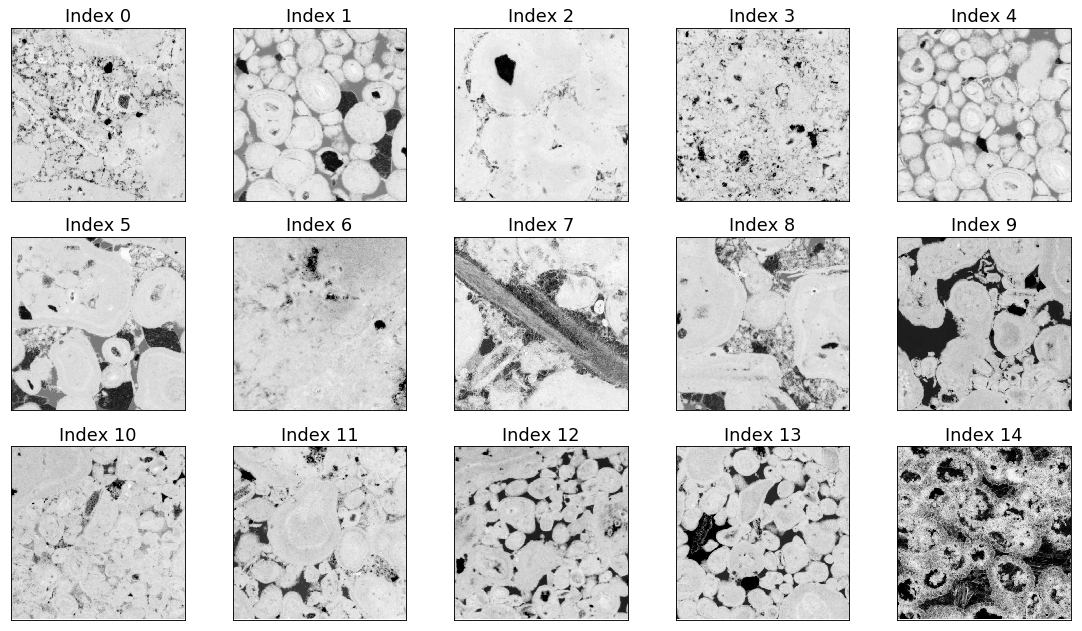

In [12]:
# Load the raw image data and convert to gray scale
raw_image_data = load_raw_image_data()  # DO NOT USE THIS DATA
visualize_image_3x5(raw_image_data, np.arange(15))

Sub-samples image data shape: (29040, 25600)


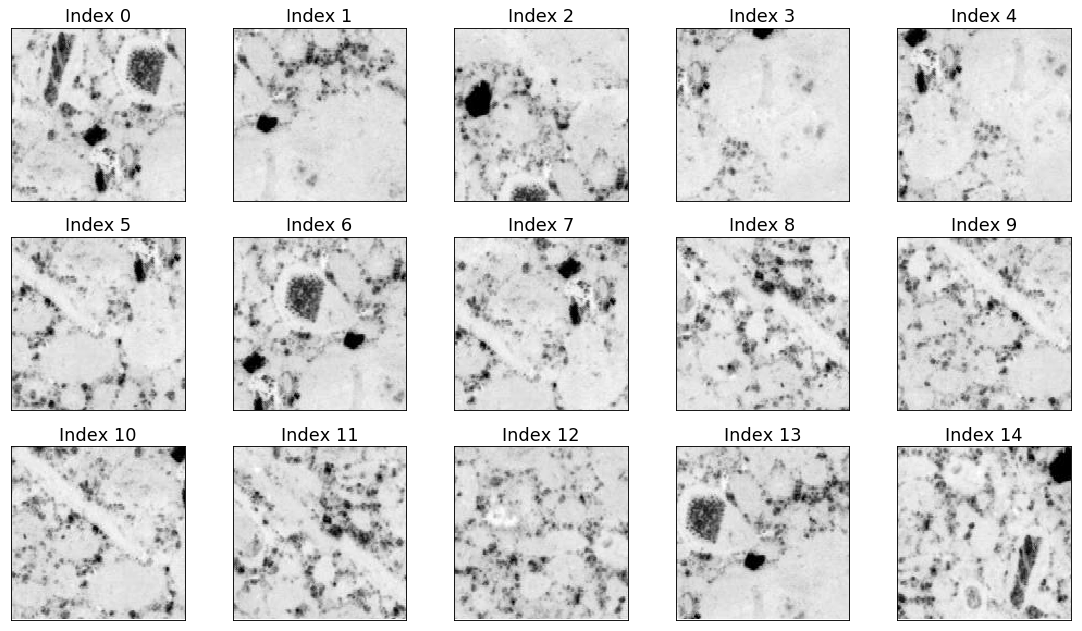

In [42]:
region_data, region_location, region_raw_index = subsample_raw_images(raw_image_data) 
visualize_image_3x5(region_data, np.arange(15))

### 2. Extract features from the raw images
    - try some of the features already implemented (linear, histogram, random features, hog, ...)
    - what would be a good feature representation to solve this problem?
    - this might be the most crucial step hence, get creative (convolutional autoencoders as feature extractors)?



In [192]:
NUM_TRAIN_SAMPLES = 1000
# data = calc_histogram_features(region_data, bins=50)
data = calc_hog_features(region_data)
train_inds = np.random.permutation(data.shape[0])[:NUM_TRAIN_SAMPLES]  # use a sub set to train  

Number of HOG features:  800


### 3. Visualize your dataset 
    - PCA, t-SNE are very good tools for visualization (cf. sklearn)
    - any group structure or isolated points; investigate?
    - does it make sense to cluster the data and examine each cluster individually?


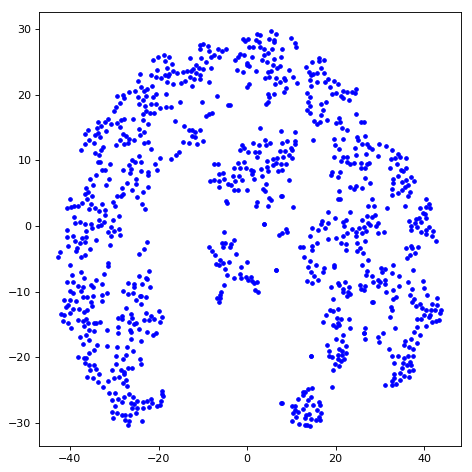

In [44]:
fig = plt.figure(figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
X_embedded = TSNE(n_components=2, init='pca').fit_transform(data[train_inds, :])
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], 10, 'b')
fig.tight_layout()

### 4. Employ anomaly detection
    - use one (or combinations) of the methods that we implemented, are available in sklearn, or in pyOD
    - does it make sense to extend methods (ie. semi-supervised)


In [216]:
RBF_PARAM = 1.0
data2 = data.copy()
data2[:, :20] = 0.
data2[:, 25:] = 0.
kernel = calc_rbf_kernel(data2[train_inds, :], data2, param=RBF_PARAM)  # RBF kernel

# kernel = calc_rbf_kernel(data[train_inds, :], data, param=RBF_PARAM)  # RBF kernel
# kernel = calc_hist_intersect_kernel(data[train_inds, :], data)  # histogram intersection kernel
# kernel = data[train_inds, :].dot(data.T)  # linear kernel
outlier_scores = one_class_svm_nu_one(kernel)

outlier_ranking = np.argsort(-outlier_scores)
print(outlier_scores.shape)
print('Memory footprint of your kernel matrix ({0}x{1} elements): {2}MB'.format(
    kernel.shape[0], kernel.shape[1], np.int(kernel.size*kernel.itemsize / (1024.*1024.))))

(29040,)
Memory footprint of your kernel matrix (1000x29040 elements): 221MB


In [217]:
outlier_scores = 1. - (outlier_scores - np.min(outlier_scores))/(np.max(outlier_scores) - np.min(outlier_scores))

### 5. Examine spectra and most anomalous images
    - is a clear anomaly pattern present?
    - what are the most anomalous regions (use provided functions to visualize), does it make sense?
    - any matches? store the result and use it for, e.g. semi-supervised learning, model selection, evaluation 
    - go back to step 2,3,4 and refine results

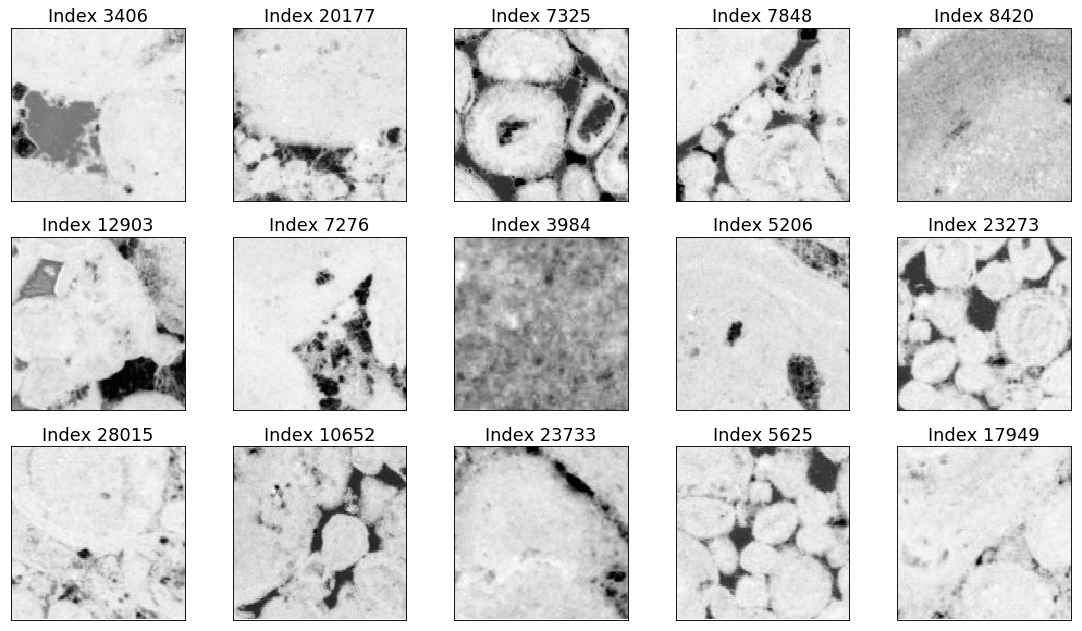

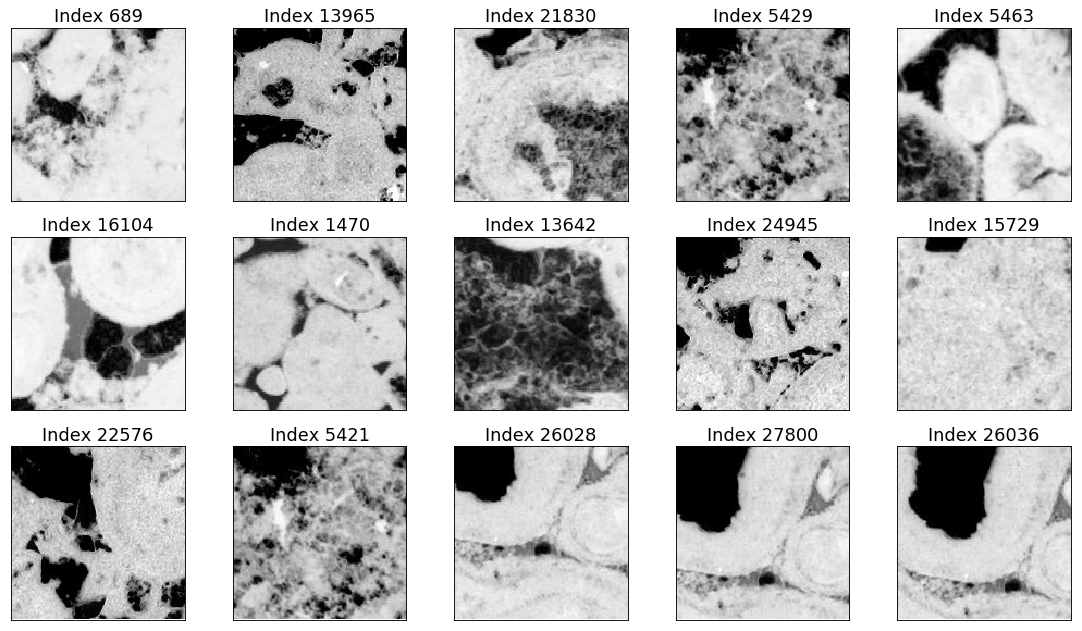

In [218]:
visualize_image_3x5(region_data, outlier_ranking[:15])  # most nominal
visualize_image_3x5(region_data, outlier_ranking[-16:-1])  # most anomaluous

800


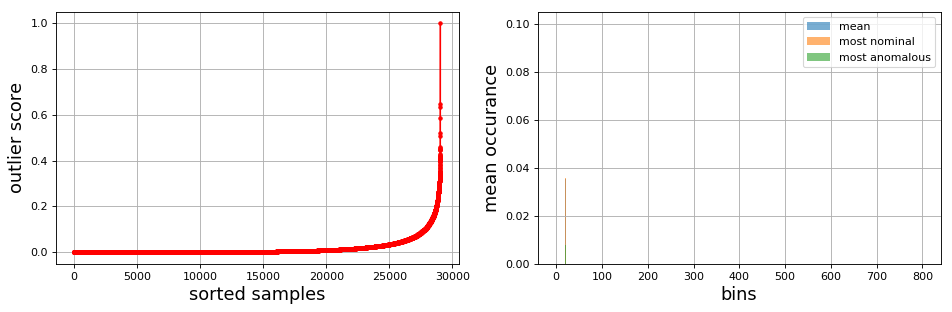

In [219]:
fig = plt.figure(figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.plot(np.arange(outlier_ranking.size), outlier_scores[outlier_ranking], '.-r')
plt.grid(True)
plt.xlabel('sorted samples', fontsize=16)
plt.ylabel('outlier score', fontsize=16)

plt.subplot(1, 2, 2)
print(data.shape[1])
plt.bar(np.arange(data.shape[1]), np.mean(data2, axis=0), alpha=0.6)
plt.bar(np.arange(data.shape[1]), data2[outlier_ranking[0], :], alpha=0.6)
plt.bar(np.arange(data.shape[1]), data2[outlier_ranking[-1], :], alpha=0.6)
plt.grid(True)
plt.legend(['mean', 'most nominal', 'most anomalous'], loc=1, fontsize=10)
plt.xlabel('bins', fontsize=16)
plt.ylabel('mean occurance', fontsize=16)

fig.tight_layout()

### 6. Combining results and visualization
    - finally, we combine all the results and show some nice heatmaps :)



(726, 262144)
(726,)
0.7824267782426777


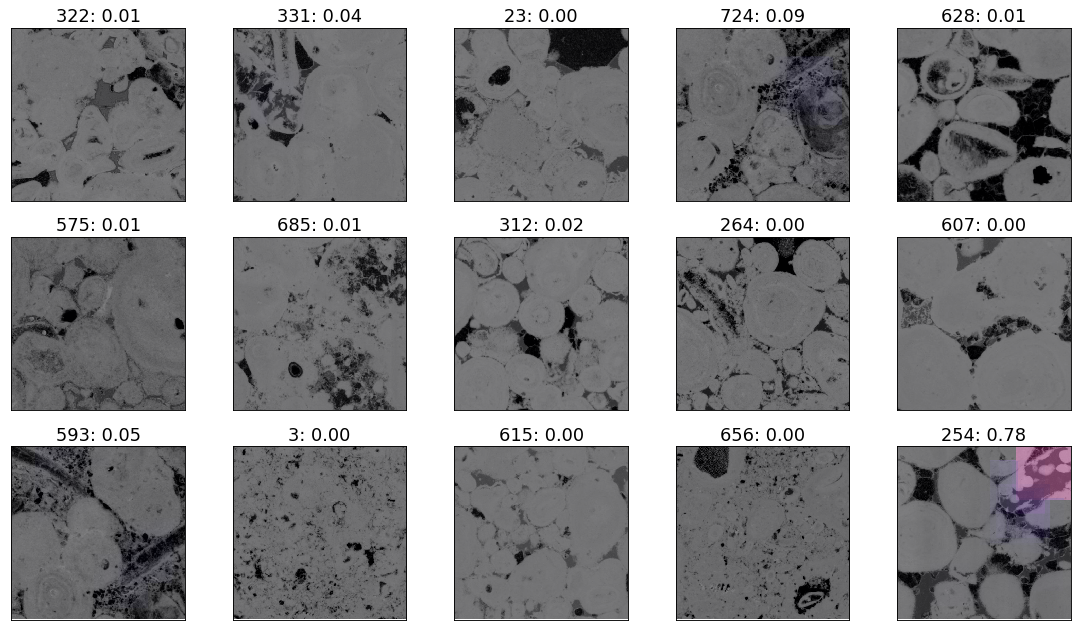

In [215]:
raw_inds = [7,57,147,190,282,335,371,551,577]
print(raw_image_data.shape)
raw_scores = get_raw_img_scores(raw_image_data, outlier_scores, region_raw_index)

lbl = np.zeros(raw_scores.size, dtype=np.int)
print(lbl.shape)
lbl[raw_inds] = 1
fpr, tpr, thresholds = metrics.roc_curve(lbl, raw_scores, pos_label=1)
print(metrics.auc(fpr, tpr))

raw_inds = np.random.permutation(raw_image_data.shape[0])
visualize_results(raw_image_data, raw_inds, outlier_scores, region_location, region_raw_index)